## Object detection Examples

### YOLO (v8 and 11)

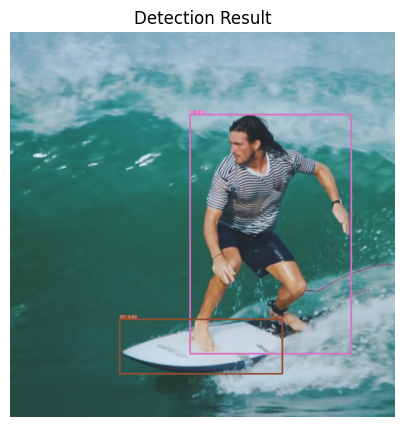

In [ ]:
from ezonnx import YOLO,visualize_images
det = YOLO("/path/to/yolo.onnx") # Please use local weight
ret = det("images/surf.jpg")                                                                                                                                                                                                                   tjjuhthghrjyjijytiofhjlhlfojho;ihj;rjth;ttkhlgkkluħ234567890qwertyuuiip[              bbbbbbbbbbbbbbbbbbbnnnnnnnnnnnnnnnnnnnnnnncsssshhhhhhhhhhhhhhhhhhhhhhhhhhh]"images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### YOLO OBB (v8 and 11)

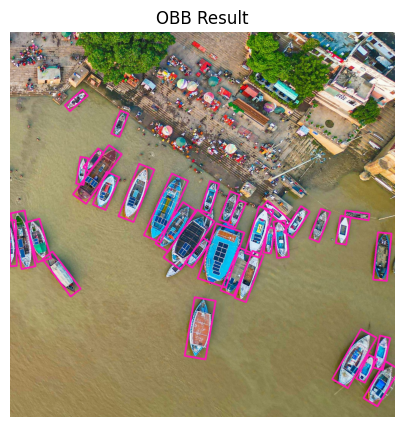

In [ ]:
from ezonnx import YOLOOBB,visualize_images
obb = YOLOOBB("/path/to/yolo-obb.onnx") # Please use local weight
ret = obb("images/port.jpg")
visualize_images("OBB Result",ret.visualized_img)

### D-FINE

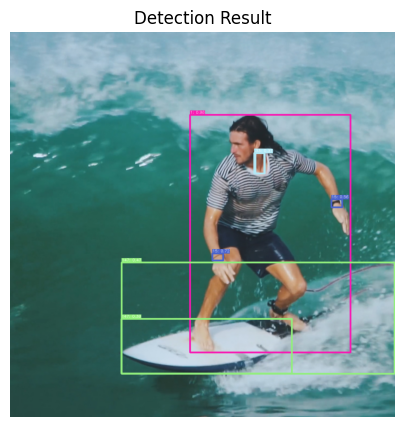

In [4]:
from ezonnx import DFINE,visualize_images
det = DFINE("s")  # you can choose "s", "m", "l", "x"
ret = det("images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### RF-DETR

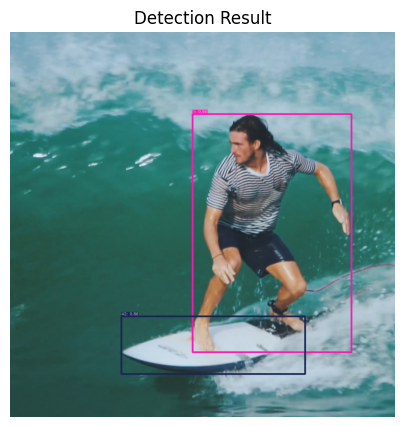

In [3]:
from ezonnx import RFDETR, visualize_images
det = RFDETR("s")
ret = det("images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### RTMDet

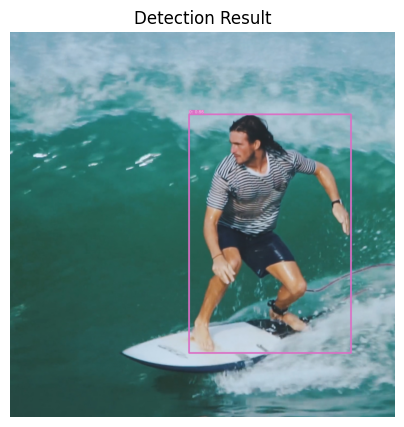

In [4]:
from ezonnx import RTMDet,visualize_images
det = RTMDet("m-person")  # you can choose "n-person","m-person","n-hand","tiny-coco","s-coco","m-coco","l-coco","x-coco")
ret = det("images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### DWPose - person whole body keypoint detection

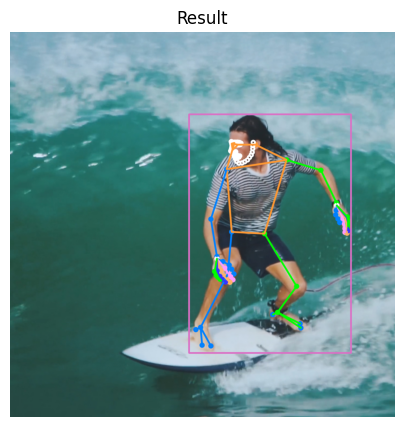

In [2]:
from ezonnx import DWPose,visualize_images
pose = DWPose()
result = pose("images/surf.jpg")
visualize_images("Result",result.visualized_img)

### RTMPose - person pose estimation

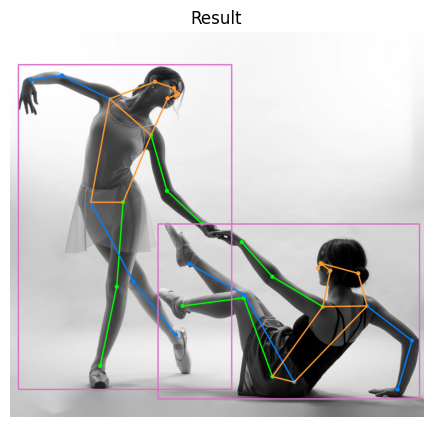

In [3]:
from ezonnx import RTMPose,visualize_images
pose = RTMPose("l") 
result = pose("images/multi_person.jpg")
visualize_images("Result",result.visualized_img)

### ViTPose-plus - person pose estimation

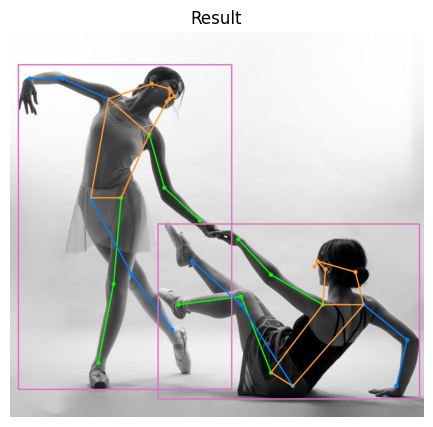

In [6]:
from ezonnx import ViTPose,visualize_images
pose = ViTPose("small") # small or base
result = pose("images/multi_person.jpg")
visualize_images("Result",result.visualized_img)

### RTMO - multi person pose detection

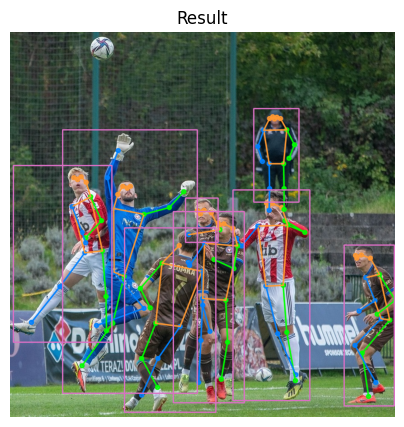

In [6]:
from ezonnx import RTMO,visualize_images
pose = RTMO("s")
result = pose("images/multi_person_1.jpg")
visualize_images("Result",result.visualized_img)

### RTMW - person whole body keypoint detection

2025-09-15 08:32:54.498736 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1709'. It is not used by any node and should be removed from the model.
2025-09-15 08:32:54.499666 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1701'. It is not used by any node and should be removed from the model.
2025-09-15 08:32:54.499695 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1706'. It is not used by any node and should be removed from the model.


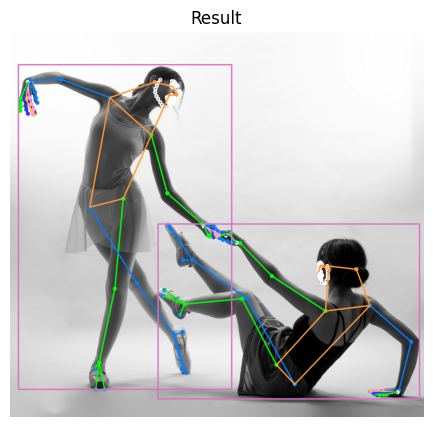

In [4]:
from ezonnx import RTMW,visualize_images
pose = RTMW("l-384") 
result = pose("images/multi_person.jpg")
visualize_images("Result",result.visualized_img)

### MotionBERT - 2D to 3D pose conversion

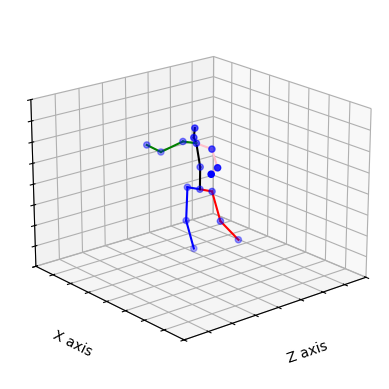

In [ ]:
from ezonnx import MotionBERT3D,show_3d_poses
mbert = MotionBERT3D(n_frames=27)
poses_3d, poses_2d = mbert("images/dance.mp4",stride=3)
show_3d_poses(poses_3d)